# OLS Regression on daily maximum temperatures in Charlottesville, VA
  
## Importing Packages

In [1]:
# Import packages
import earthpy
import holoviews as hv
import hvplot.pandas
import pandas as pd
import numpy as np

# Advanced options on matplotlib/seaborn/pandas plots
import matplotlib.pyplot as plt
# Common statistical plots for tabular data
import seaborn as sns
# Fit an OLS linear regression
from sklearn.linear_model import LinearRegression

## Downloading & Formatting Data

In [2]:
# Create Charlotteville URL variable using the USC00441593 Station
cville_url = ('https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily'
'-summaries&dataTypes=TMAX&stations=USC00441593&startDate=1893-01-01&endDate'
'=2024-12-31&units=standard')
cville_url

'https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&dataTypes=TMAX&stations=USC00441593&startDate=1893-01-01&endDate=2024-12-31&units=standard'

In [3]:
# Download the climate data
cville_raw_df = pd.read_csv(
    cville_url,
    index_col='DATE',
    parse_dates=True,
    na_values=['NaN']
)

# Check that the download worked
cville_raw_df

,STATION,TMAX
DATE,,
1893-01-01,USC00441593,44.0
1893-01-02,USC00441593,NaN
1893-01-03,USC00441593,36.0
1893-01-04,USC00441593,28.0
1893-01-05,USC00441593,23.0
...,...,...
2024-12-27,USC00441593,49.0
2024-12-28,USC00441593,43.0
2024-12-29,USC00441593,62.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45366 entries, 1893-01-01 to 2024-12-31
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  45366 non-null  object 
 1   TMAX     45161 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.0+ MB


<Axes: ylabel='Frequency'>

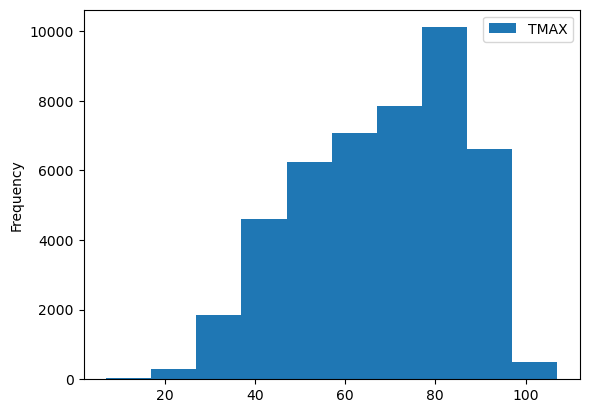

In [4]:
# Confirming data type, information, expexted range of values
type(cville_raw_df)

cville_raw_df.info()

cville_raw_df.plot.hist()

In [5]:
# Removing the Station ID column since it does not change
cville_df = cville_raw_df[["TMAX"]]

# Adding column for celsius conversion, rounding to three decimals
cville_df['Max_Celsius'] = round((cville_df['TMAX']-32) * (5/9), 3)
cville_df

,TMAX,Max_Celsius
DATE,,
1893-01-01,44.0,6.667
1893-01-02,NaN,NaN
1893-01-03,36.0,2.222
1893-01-04,28.0,-2.222
1893-01-05,23.0,-5.000
...,...,...
2024-12-27,49.0,9.444
2024-12-28,43.0,6.111
2024-12-29,62.0,16.667


In [6]:
# Remove TMAX column after confirming calculation accuracy
cville_df = cville_df[["Max_Celsius"]]
cville_df

,Max_Celsius
DATE,
1893-01-01,6.667
1893-01-02,NaN
1893-01-03,2.222
1893-01-04,-2.222
1893-01-05,-5.000
...,...
2024-12-27,9.444
2024-12-28,6.111
2024-12-29,16.667


## Plotting & Resampling

<Axes: title={'center': 'Charlottesville Daily Max Temp 1893 - 2024'}, xlabel='Year', ylabel='Temperature  ($^\\circ$C)'>

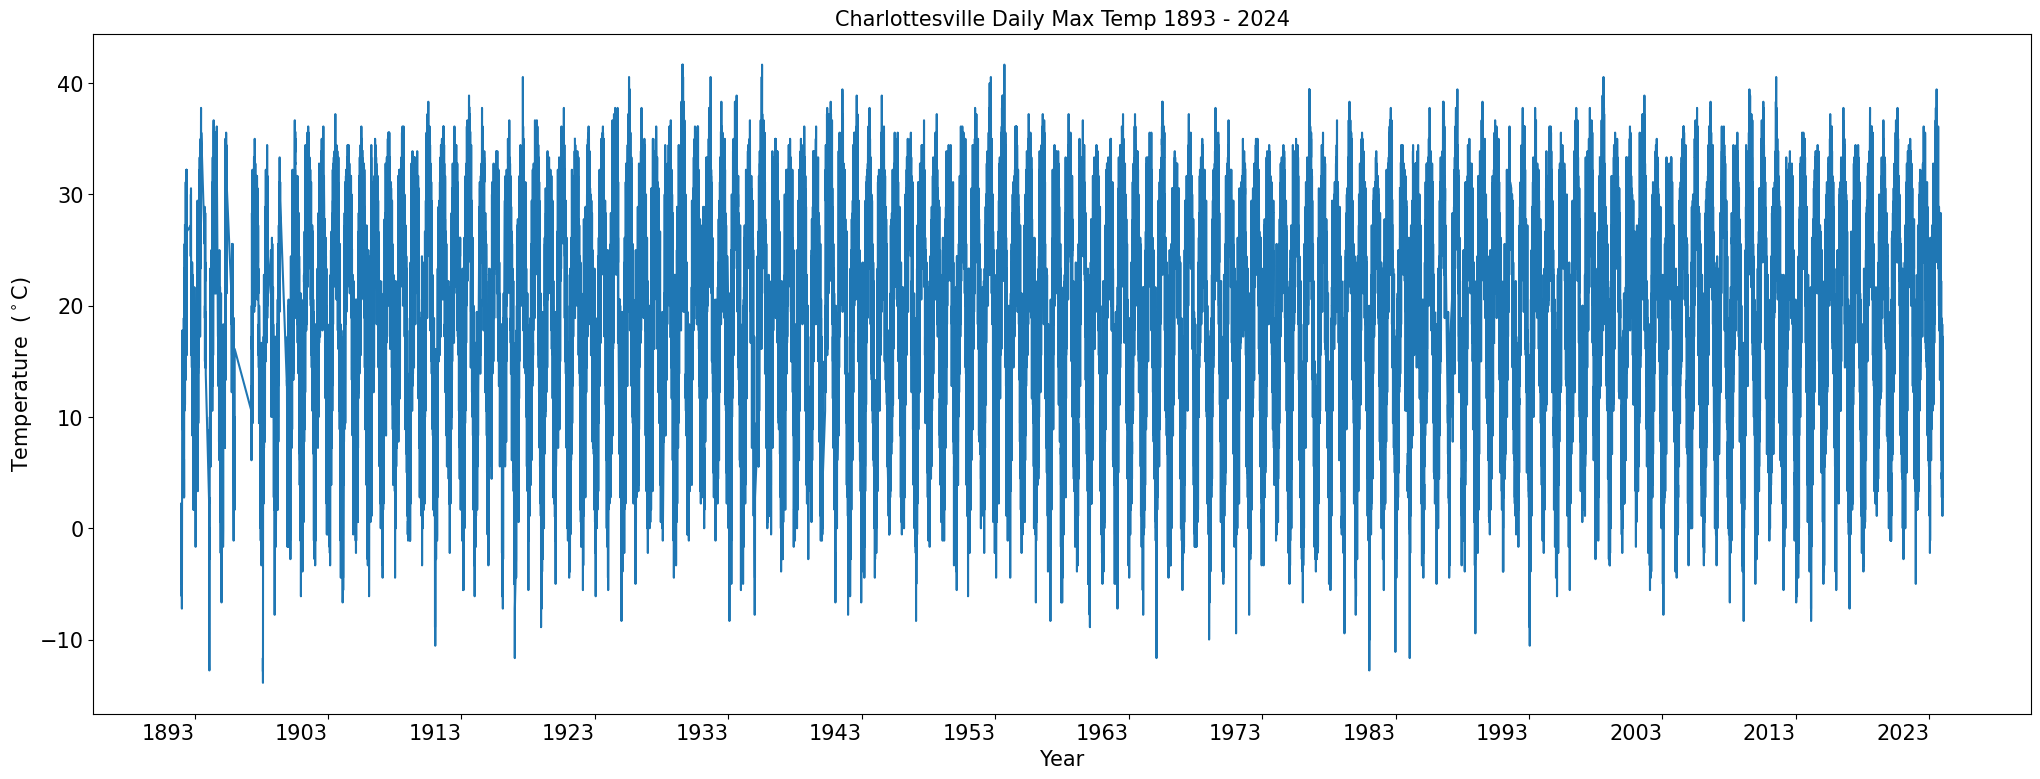

In [7]:
# Plot all daily data points
cville_plot = cville_df.plot(
    y='Max_Celsius',
    legend=False,
    fontsize=15,
    figsize=(25,10)
    )

# Change titles and axis label font sizes directly when changing figsize
cville_plot.set_title('Charlottesville Daily Max Temp 1893 - 2024', fontsize=15)
cville_plot.set_xlabel('Year', fontsize=15)
cville_plot.set_ylabel('Temperature  ($^\circ$C)', fontsize=15)

# Generate x axis label every 10 years instead of 20
xlabels = pd.date_range(start=cville_df.index.min(), end=cville_df.index.max(), 
                       freq='10YE')

# Set the ticks to the plot
cville_plot.set_xticks(xlabels)

# Format x axis labels to show only the year
cville_plot.set_xticklabels([tick.year for tick in xlabels])

# Rotate x axis labels
plt.setp(cville_plot.xaxis.get_majorticklabels(), rotation=0)

cville_plot

In [8]:
# Improve usability by resampling for the mean Max_Celsius value each year
# 1897 is missing entirely from the data

ann_cville_df = (
    cville_df
    .resample('YS')
    .mean()
)
ann_cville_df

,Max_Celsius
DATE,
1893-01-01,15.493014
1894-01-01,20.793167
1895-01-01,19.621053
1896-01-01,15.744852
1897-01-01,NaN
...,...
2020-01-01,19.959030
2021-01-01,20.465756
2022-01-01,19.737522


In [9]:
# Interactive plot with resampled values for all years except 1897
cville_int_plot = ann_cville_df.hvplot(
    y='Max_Celsius',
    xlabel='Year',
    ylabel='Temperature (°C)',
    title='Yearly Average Max Daily Temp in Charlottesville, VA'
)

# Save the html file in the media folder
hv.save(cville_int_plot, 'media/cville_int_plot.html')

cville_int_plot

:Curve   [DATE]   (Max_Celsius)

In [10]:
# Fit an OLS Linear Regression to the data

# Drop years missing data from analysis
ann_cville_smooth_df = ann_cville_df.dropna()

# Define variables
x = ann_cville_smooth_df.index.year.values.reshape(-1, 1)
y = ann_cville_smooth_df['Max_Celsius']

# Create and fit the linear regression model
model = LinearRegression()
model.fit(x, y)

# Calculate and print slope
print(f'The slope of the trend line is {model.coef_[0]} degrees per year')

The slope of the trend line is 0.0003399354546728873 degrees per year


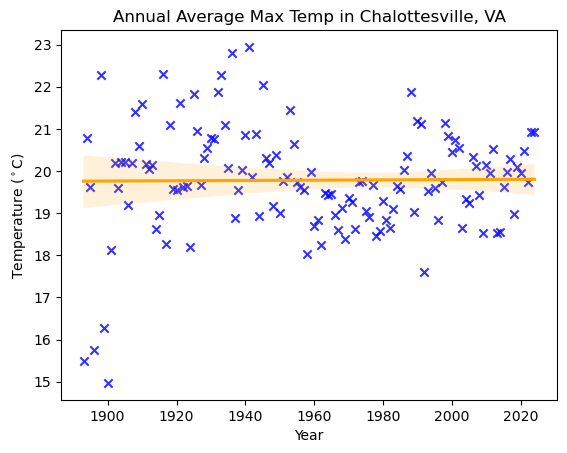

The slope of the OLS regression trend line is 0.0003399354546728873 degrees increase per year


In [11]:
# Plot the regression
ax = sns.regplot(
    x = ann_cville_smooth_df.index.year, 
    y = ann_cville_smooth_df.Max_Celsius,
    color = 'blue',
    line_kws = {'color' : 'orange'},
    marker="x",
    label = 'test1'
)

# Set plot labels
ax.set(
    title='Annual Average Max Temp in Chalottesville, VA',
    xlabel='Year',
    ylabel='Temperature ($^\circ$C)',
    label = 'test2'
)

# Save plot
plt.savefig('/workspaces/02-climate-cmcara/media/cville_climate_reg_full.jpeg')

# Display the plot without extra text
plt.show()

# Display Slope as well
print(f'The slope of the OLS regression trend line is {model.coef_[0]} degrees increase per year')

## Initial Takeaways
Using the entire range of data, we see a positively sloped trend line of 0.0003399354546728873 degrees increase per year. This is a very small correlation and lags behind most estimates of average annual temperature increase by multiple orders of magnitude ([Link](https://www.climate.gov/news-features/understanding-climate/climate-change-global-temperature)). 

The more surprising result of this exercise was the variability I encountered when implementing different cut-offs for which years to include in the data. Given that some years in the data do not have a complete record for each day in that year, there is some bias in resampling each year by a mean value and considering all years' means equallly. 

I initially established a parameter that a year would need ≥ 330 observations of a possible 365 (or 366) to be considered for the regression. This would mean that each year in the new regression would have less than one month of total missing data and would be more accurate for the analysis, but I instead found a negative trend line of -0.0005946989952838821 degrees/year. Relaxing the parameter to 300 observations means the trend line becomes an order of magnitude more negative at -0.0045373587845689905 degrees/year. With the most restrictive practical value of 365 days of data required for a year to be considered, I find a positively slopped trend line of 0.004891213862698849 degress/year. All of the cutoff values considered could be realistically argued as valid, and I believe this is an exagerated example of analytics being open to manipulation without sufficient data. 

If the trend line using the 330 observation cutoff had been positive as I expected, I might not have looked any deeper. If I wanted to try to provide proof against some element of global warming or climate change, this might have been a welcome result. Because manipulating the parameters within a realist range leads to such varied results, I believe we need more data (as always).

## Repeat of OLS regression using 330 observation cutoff

In [12]:
# Cut off years with less than 330 total observations prior to resampling

# Add column for year
cville_df['year']=cville_df.index.year

# Variables for cutoff amount and counts
param1 = 330
counts = cville_df['year'].value_counts()

# Variables for qualifying years
valid_years = counts[counts >= param1].index
invalid = counts[counts < param1].index

# Filter out invalid years
cville_clean_df = cville_df[cville_df['year'].isin(valid_years)].copy()

# Remove the year columns
cville_df = cville_df[["Max_Celsius"]]
cville_clean_df = cville_clean_df[["Max_Celsius"]]

# Print list of years excluded and new dataset
print(invalid)
cville_clean_df

Index([1945, 1933, 1940, 1926, 1936, 1941, 1992, 1987, 1908, 1910, 1895, 1925,
       1899, 1988, 1916, 1898, 1893, 1896, 1894, 1900],
      dtype='int32', name='year')


,Max_Celsius
DATE,
1901-01-01,11.667
1901-01-02,6.111
1901-01-03,0.556
1901-01-04,6.667
1901-01-05,7.222
...,...
2024-12-27,9.444
2024-12-28,6.111
2024-12-29,16.667


In [13]:
# Resample the 'clean' dataset in the same way as above
ann_cville_clean_df = (
    cville_clean_df
    .resample('YS')
    .mean()
)
ann_cville_clean_df

,Max_Celsius
DATE,
1901-01-01,18.118353
1902-01-01,20.190722
1903-01-01,19.591261
1904-01-01,20.217224
1905-01-01,20.207441
...,...
2020-01-01,19.959030
2021-01-01,20.465756
2022-01-01,19.737522


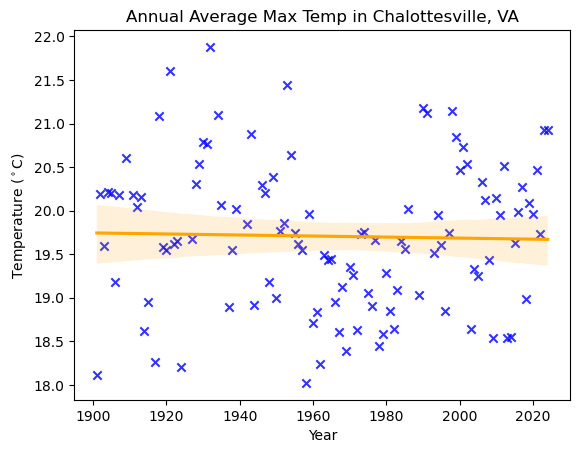

The slope of the OLS regression trend line with a 330 observation cutoff is -0.0005946989952838821 degrees per year


In [14]:
# Run the regression again on new dataset

# Drop years missing data from analysis
ann_cville_clean_df = ann_cville_clean_df.dropna()

# Define variables
x = ann_cville_clean_df.index.year.values.reshape(-1, 1)
y = ann_cville_clean_df['Max_Celsius']

# Create and fit the linear regression model
model = LinearRegression()
model.fit(x, y)

# Plot
ax = sns.regplot(
    x = ann_cville_clean_df.index.year, 
    y = ann_cville_clean_df.Max_Celsius,
    color = 'blue',
    line_kws = {'color' : 'orange'},
    marker="x"
)

# Set plot labels
ax.set(
    title='Annual Average Max Temp in Chalottesville, VA',
    xlabel='Year',
    ylabel='Temperature ($^\circ$C)'
)

# Save plot
plt.savefig('/workspaces/02-climate-cmcara/media/cville_climate_reg_330.jpeg')

# Display the plot without extra text
plt.show()

# Display Slope as well
print(f'The slope of the OLS regression trend line with a 330 observation cutoff is {model.coef_[0]} degrees per year')

## Calculating OLS trend line slope for various cutoffs

In [15]:
# Calculation OLS rend line slope for various cutoff parameters

cville_test_df = cville_df
cville_test_df['year']=cville_df.index.year

param_list = [0, 200, 300, 320, 330, 350, 365]

for i in param_list:
    # Establish variables
    param = i
    counts = cville_test_df['year'].value_counts()
    # Filter out invalid years
    valid_years = counts[counts >= param].index
    cville_cleaner_df = cville_test_df[cville_test_df['year'].isin(valid_years)].copy()
    # Resample
    ann_cville_test_df = (
        cville_cleaner_df
        .resample('YS')
        .mean()
        )
    # Drop NA values
    ann_cville_cleanest_df = ann_cville_test_df.dropna()
    # Establish regression variables
    x = ann_cville_cleanest_df.index.year.values.reshape(-1, 1)
    y = ann_cville_cleanest_df['Max_Celsius'] 
    # Create and fit the linear regression model
    model = LinearRegression()
    model.fit(x, y)
    # Calculate and print slope
    print(f'The slope of the trend line with cutoff {i} is {model.coef_[0]}'
          'degrees per year')

The slope of the trend line with cutoff 0 is 0.0003399354546728873degrees per year
The slope of the trend line with cutoff 200 is -0.002385347195884794degrees per year
The slope of the trend line with cutoff 300 is -0.0045373587845689905degrees per year
The slope of the trend line with cutoff 320 is -0.0005946989952838821degrees per year
The slope of the trend line with cutoff 330 is -0.0005946989952838821degrees per year
The slope of the trend line with cutoff 350 is 0.004803050372804026degrees per year
The slope of the trend line with cutoff 365 is 0.004891213862698849degrees per year
